In [2]:
# see https://github.com/Snowflake-Labs/sfguide-intro-to-machine-learning-with-snowpark-ml-for-python/blob/main/3_snowpark_ml_model_training_inference.ipynb

from snowflake.snowpark import Session
from snowflake.ml.utils.connection_params import SnowflakeLoginOptions

pars = SnowflakeLoginOptions("test_conn")
# pars["warehouse"] = "COMPUTE_WH"
session = Session.builder.configs(pars).create()
session.query_tag = "regressor-metrics-2"

df = session.table("test.diamonds.diamonds_transform_pipeline")
df.show()

train_df, test_df = df.random_split(weights=[0.9, 0.1], seed=0)

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CARAT"               |"DEPTH"              |"TABLE_PCT"          |"X"                  |"Y"                  |"Z"                  |"CUT_OE"  |"COLOR_OE"  |"CLARITY_OE"  |"COLOR"  |"CLARITY"  |"PRICE"  |"CUT"      |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|0.006237006237006237  |0.5138888888888888   |0.23076923076923073  |0.3677839851024209   |0.06757215619694397  |0.07641509433962265  |0.0       |1.0         |6.0           |E        |SI2        |326      |IDEAL      |
|0.002079002079002079  |0.46666666666666656  |0.34615384615384615  |0.36219739292364994  |0.06519524617996604  |0.07264150943396

In [3]:
from snowflake.ml.modeling.xgboost import XGBRegressor
from snowflake.ml.modeling.model_selection import GridSearchCV

session.sql("USE WAREHOUSE LARGE").collect()
model = GridSearchCV(
    estimator=XGBRegressor(),
    param_grid={
        "n_estimators": [100, 200, 300, 400, 500],
        "learning_rate": [0.1, 0.2, 0.3, 0.4, 0.5] },
    n_jobs = -1,
    scoring="neg_mean_absolute_percentage_error",
    input_cols=["CUT_OE", "COLOR_OE", "CLARITY_OE", "CARAT", "DEPTH", "TABLE_PCT", "X", "Y", "Z"],
    label_cols=['PRICE'],
    output_cols=['PREDICTED_PRICE'])
model.fit(train_df)

session.sql("USE WAREHOUSE COMPUTE_WH").collect()
model.to_sklearn().best_estimator_

[07:16:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.



c:\Projects\snowflake-cortex\venv\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.4, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=3, num_parallel_tree=None, predictor=None,
             random_state=None, ...)

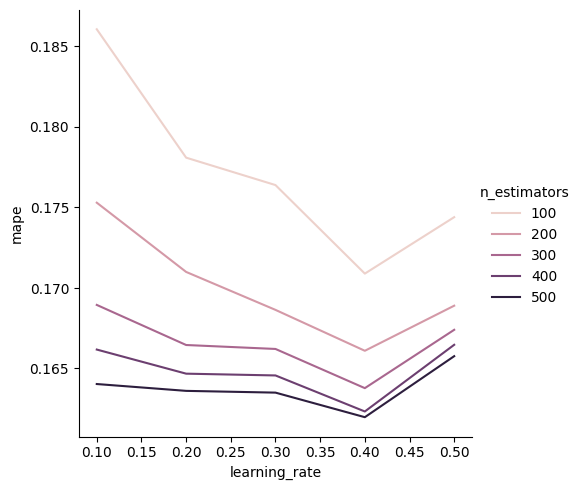

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

res = model.to_sklearn().cv_results_
est, lr = [], []
for dict in res["params"]:
    est.append(dict["n_estimators"])
    lr.append(dict["learning_rate"])
mape_val = res["mean_test_score"] * -1

df2 = pd.DataFrame(data={"n_estimators": est, "learning_rate": lr, "mape": mape_val})
sns.relplot(data=df2, x="learning_rate", y="mape", hue="n_estimators", kind="line")
plt.show()

In [5]:
from snowflake.ml.modeling.metrics import mean_absolute_percentage_error

pred = model.predict(test_df)
pred.select("PRICE", "PREDICTED_PRICE").show()

mape = mean_absolute_percentage_error(
    df=pred, 
    y_true_col_names="PRICE", 
    y_pred_col_names="PREDICTED_PRICE")
print(f"Mean absolute percentage error: {mape}")

--------------------------------
|"PRICE"  |"PREDICTED_PRICE"   |
--------------------------------
|351      |353.2740173339844   |
|353      |343.84271240234375  |
|355      |431.1207275390625   |
|357      |355.054443359375    |
|554      |560.3695068359375   |
|554      |527.7815551757812   |
|2757     |2796.111083984375   |
|2759     |2878.782958984375   |
|2759     |3021.80224609375    |
|2762     |2838.24658203125    |
--------------------------------

Mean absolute percentage error: 0.06614988993792766
